In [1]:
import biom
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Joint microbe / metabolite analysis

In [2]:
mmV = pd.read_excel('../results/microb_metabolites_analysis (3).xlsx', 
                    sheet_name='Figure V', index_col=0)

microbe_fmd = pd.read_excel('../results/microb_metabolites_analysis (3).xlsx', 
                    sheet_name='microbiome_meta', index_col=0)
metabolite_fmd = pd.read_excel('../results/microb_metabolites_analysis (3).xlsx', 
                               sheet_name='Metabolites_meta', index_col=0)

microbe_fmd['OTUID'] = list(map(lambda x: f'X{x}', microbe_fmd.index))
microbe_fmd = microbe_fmd.reset_index().set_index('OTUID')

midx = np.array(list(map(lambda x: x in set(microbe_fmd.index), mmV.index)))
microbeV2 = mmV.loc[midx]
metaboliteV2 = mmV.loc[~midx]
metaboliteV2.index = metabolite_fmd['sampleid'].values

Microbial sample metadata

In [3]:
!ls ../data/

cleaned-data                          instrument.txt
combined                              phenotype.txt
hcc-data                              sample_information_from_prep_2458.tsv


In [4]:
instruments = pd.read_table('../data/instrument.txt', index_col=0)
phenotype = pd.read_table('../data/phenotype.txt', index_col=0)

confounder = pd.read_csv('../data/cleaned-data/microbiome_confounder.csv', index_col=0)
family = pd.read_csv('../data/cleaned-data/microbiome_family.csv', index_col=0)
instrument = pd.read_csv('../data/cleaned-data/microbiome_instrume.csv', index_col=0)
outcome = pd.read_csv('../data/cleaned-data/microbiome_outcome.csv', index_col=0)

outcome.index = family.index # fingers crossed!
instrument.index = family.index 
confounder.index = family.index 

microbe_md = pd.merge(outcome, confounder, left_index=True, right_index=True)
microbe_md = pd.merge(microbe_md, instruments, left_index=True, right_index=True)

otu_table = biom.load_table('../data/hcc-data/46119_otu_table.biom').to_dataframe().T
otu_table.columns = list(map(lambda x: f'X{x}', otu_table.columns))
family = otu_table.loc[microbe_md.index]

Metabolomics sample metadata

In [5]:
import biom
metabolites = biom.load_table('../data/hcc-data/metabolites.biom').to_dataframe().T
metabolite_md = pd.read_table('../data/hcc-data/metabolite_feature_metadata.txt', index_col=0)
metabolites = metabolites[metabolite_md.index]

metadata = pd.read_table('../data/hcc-data/cleaned_qiime_metadata.txt', index_col=0)
host_md = pd.read_table('../data/sample_information_from_prep_2458.tsv', index_col=0)
metadata = pd.merge(metadata, host_md[['host_subject_id']].reset_index(), 
                    left_index=True, right_on='host_subject_id')

del microbe_md['obese']
del microbe_md['HCC']

metadata = pd.merge(metadata, microbe_md.reset_index(), left_on='sample_id', right_on='index')
metadata = metadata.set_index('host_subject_id')
metadata, metabolites = metadata.align(metabolites, join='inner', axis=0)
metabolites = metabolites.loc[:, metabolite_fmd['sampleid'].values]

# re-align microbial data
family = family.loc[metadata['sample_id'].values]
family.index = metadata.index

Summaries

In [6]:
# metabolite balance
bname = 'V1'
#thres = 0.005
thres = 0
metabolite_ranks = metaboliteV2[bname].sort_values()
denom = metabolite_ranks.loc[metabolite_ranks < -thres].index
num = metabolite_ranks.loc[metabolite_ranks > thres].index
#v = pd.DataFrame({
#    f'metabolite{bname}' : np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)
#})
v = np.log(metabolites[num] + 1).mean(axis=1) - np.log(metabolites[denom] + 1).mean(axis=1)
#metadata = pd.merge(metadata, v, left_index=True, right_index=True)
metadata[f'metabolite{bname}'] = v

# microbe balance
#thres = 0.005
thres = 0
microbe_ranks = microbeV2[bname].sort_values()
denom = microbe_ranks.loc[microbe_ranks < -thres].index
num = microbe_ranks.loc[microbe_ranks > thres].index
#v = pd.DataFrame({
#    f'microbe{bname}' : np.log(family[num] + 1).mean(axis=1) - np.log(family[denom] + 1).mean(axis=1)
#})
v = np.log(family[num] + 1).mean(axis=1) - np.log(family[denom] + 1).mean(axis=1)
#metadata = pd.merge(metadata, v, left_index=True, right_index=True)
metadata[f'microbe{bname}'] = v

/Users/mortonjt/miniconda3/envs/iv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/mortonjt/miniconda3/envs/iv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='V1', ylabel='Density'>

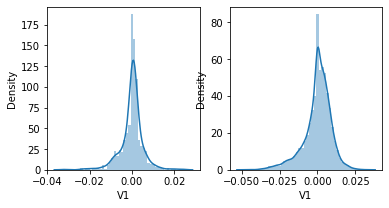

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.distplot(microbe_ranks, ax=ax[0])
sns.distplot(metabolite_ranks, ax=ax[1])

Metabolite balance

Text(0.5, 0, 'obesity')

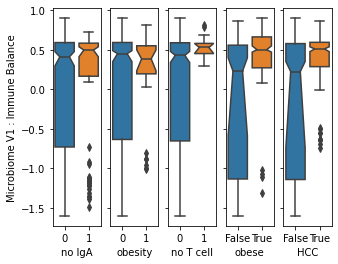

In [8]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metadata, y=f'microbe{bname}', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='obese', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metadata, y=f'microbe{bname}', x='HCC', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel(f'Microbiome {bname} : Immune Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

Text(0.5, 0, 'obesity')

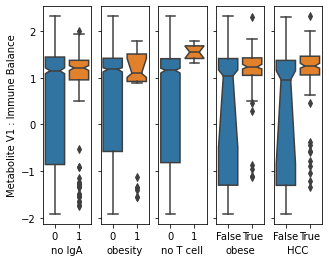

In [9]:
fig, ax = plt.subplots(1, 5, sharey=True, figsize=(5, 4))

sns.boxplot(data=metadata, y=f'metabolite{bname}', x='no IgA', notch=True, ax=ax[0], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='no B cell', notch=True, ax=ax[1], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='no T cell', notch=True, ax=ax[2], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='obese', notch=True, ax=ax[3], bootstrap=1000)
sns.boxplot(data=metadata, y=f'metabolite{bname}', x='HCC', notch=True, ax=ax[4], bootstrap=1000)

ax[0].set_ylabel(f'Metabolite {bname} : Immune Balance')
for i in range(1, 5):
    ax[i].set_ylabel('')
ax[1].set_xlabel('obesity')

In [10]:
from scipy.stats import ttest_ind
ttest_ind(metadata['microbeV1'].loc[metadata['HCC']],
          metadata['microbeV1'].loc[~metadata['HCC']])

Ttest_indResult(statistic=9.901593984453823, pvalue=7.56399993839683e-21)

In [11]:
ttest_ind(metadata['metaboliteV1'].loc[metadata['HCC']],
          metadata['metaboliteV1'].loc[~metadata['HCC']])

Ttest_indResult(statistic=10.094170676018951, pvalue=1.5893850536050762e-21)

In [12]:
microbe_fmd = pd.merge(microbeV2, microbe_fmd, 
                       left_index=True, right_index=True).sort_values('V1')

In [30]:
microbe_fmd = microbe_fmd.rename(columns={'V1_x' : 'V1'})

In [14]:
metabolite_fmd = pd.merge(metaboliteV2,
                          metabolite_fmd.set_index('sampleid'), 
                          left_index=True, right_index=True)

In [15]:
metabolite_fmd

,V1,V2,V3,V4,V5,Intercept,diet.T.NC.,mz,rt,nearest_distance,...,motif_478,motif_338,gnps_motif_43.m2m.http...ms2lda.org.motifdb.motif.151021.Water.loss...indicative.of.a.free.hydroxyl.group....in.beer.often.seen.in.sugary.structures.,motif_388,motif_306,gnps_motif_38.m2m.http...ms2lda.org.motifdb.motif.151045.Loss.of.CH2O2...indicative.for.underivatized.carboxilic.acid.group,motif_559,motif_451,motif_443,motif_469
357.278921944848_6.78255773651635,-0.000402,-0.011556,0.020835,0.005655,0.0,6.639105,1.608602,357.278922,406.953464,7.800464,...,False,False,False,False,False,False,False,False,False,False
375.289157255286_6.79100745149911,-0.001986,-0.011490,0.019707,0.014482,0.0,6.507710,-0.640123,375.289157,407.460447,5.057447,...,False,False,False,False,False,False,False,False,False,True
373.273770443826_5.10086137440758,0.000619,-0.024345,0.015396,0.017116,0.0,6.333313,-0.131551,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
373.273686528335_4.84083244725738,0.000000,-0.010191,0.000000,0.008944,0.0,6.188790,-0.026041,373.273687,290.449947,9.800209,...,False,False,False,False,False,False,False,False,False,False
391.284342734904_6.30942060301507,-0.005812,-0.007975,0.021322,0.000916,0.0,5.712242,-0.436180,391.284343,378.565236,6.526236,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361.272818801043_8.38321917077176,0.000340,0.014843,-0.006906,-0.007680,0.0,-0.903152,-0.089544,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
545.791125197703_3.36571988382483,0.000205,-0.006456,0.000000,0.005584,0.0,-0.781770,-0.546678,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
330.269609799664_6.23307150537634,0.002742,0.007130,0.023785,-0.014982,0.0,-0.727299,-0.794258,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
584.36345704229_3.78418134199134,0.002533,-0.008039,0.000000,0.002490,0.0,-0.561481,-0.732218,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [16]:
(metabolite_fmd
 .sort_values('V1')
 #.dropna(subset='Compound_Name')
 .tail(50)[['V1', 'Compound_Name']])

,V1,Compound_Name
486.219890738663_6.98758795833332,0.021987,NaN
308.265911300452_6.91674047619047,0.022000,Spectral Match to Linolenic acid ethyl ester f...
486.220036813855_6.98649529166666,0.022059,NaN
331.2265194383_4.74227724458204,0.022316,NaN
318.160132649287_5.9760713063063,0.022328,NaN
468.2094939576_7.05160048780487,0.022409,NaN
433.200163076445_6.95572470978441,0.022423,NaN
439.290439121464_3.54185966958211,0.022568,NaN
459.310227183102_8.1399475578406,0.022803,NaN
308.267253119937_6.91951650906225,0.022809,Spectral Match to Linolenic acid ethyl ester f...


In [17]:
# flip sign because of U
microbe_fmd = pd.merge(microbe_fmd, microbe_ranks, left_index=True, right_index=True)

In [32]:
microbe_fmd

,V1,V2,V3,V4,V5,index,Kingdom,Phylum,Class,Order,Family,Genus,Species
X174500,-0.032413,-0.001665,0.000000,-0.004689,0.0,174500,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__S24-7,g__,s__
X4449526,-0.023606,0.000000,0.000000,0.007804,0.0,4449526,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__
X3172943,-0.023533,0.000000,0.011366,0.000000,0.0,3172943,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__S24-7,g__,s__
X38278,-0.021455,0.000000,0.000382,0.000000,0.0,38278,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__S24-7,g__,s__
X2212505,-0.020628,-0.000730,-0.003458,0.003009,0.0,2212505,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__S24-7,g__,s__
...,...,...,...,...,...,...,...,...,...,...,...,...,...
X261590,0.017451,-0.013020,0.005819,0.001834,0.0,261590,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Peptostreptococcaceae,g__,s__
X262633,0.019667,-0.013207,0.014652,0.016871,0.0,262633,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Lachnospiraceae,g__[Ruminococcus],s__gnavus
X258421,0.019895,-0.016358,0.006847,0.005800,0.0,258421,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,g__Allobaculum,s__
X184451,0.022626,-0.017554,0.015722,0.000452,0.0,184451,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__,g__,s__


In [31]:
microbe_fmd.to_csv('../results/microbiome_clr_ranks.csv')

In [20]:
# flip sign because of U
metabolite_ranks.sort_values()

441.372182893918_8.58051588966588   -0.049006
310.708817070852_8.57915795262267   -0.046260
310.708800945131_8.57546539115646   -0.045963
359.326482884576_5.26957420091324   -0.044443
359.327109138622_5.26726356321838   -0.044214
                                       ...   
504.310302325298_5.95452708871662    0.029439
479.336777450062_7.03288854748603    0.031058
479.337100519155_7.03315788982259    0.031521
455.298740774056_6.13995540935672    0.033210
479.335724021822_7.63489370892018    0.033977
Name: V1, Length: 11781, dtype: float64

In [21]:
metabolite_fmd[['Compound_Name', 'V3']].sort_values('V3').dropna().head(10)

,Compound_Name,V3
390.265335965471_6.0829833912037,Spectral Match to 12-Ketodeoxycholic acid from...,-0.048807
392.281056526824_6.44771632653061,Spectral Match to 12-Ketodeoxycholic acid from...,-0.047451
392.281122607748_6.14665450292397,Spectral Match to 12-Ketodeoxycholic acid from...,-0.046511
482.318288296035_7.12349178470254,Spectral Match to 1-Pentadecanoyl-sn-glycero-3...,-0.041659
413.25789873731_6.40420444947209,"NCGC00385811-01!6-[3-[(3,4-dimethoxyphenyl)met...",-0.038208
301.632027343066_7.21069945355191,MLS001066334-01!D-erythro-Dihydrosphingosine76...,-0.035060
510.384305053742_8.71148360433603,Spectral Match to 1-Octadecyl-sn-glycero-3-pho...,-0.032864
375.284220887573_6.1744086086086,Spectral Match to Ursodeoxycholic acid from NI...,-0.031925
401.340710574401_8.01456437659032,Spectral Match to Palmitoylcarnitine from NIST14,-0.031218
359.287032083315_7.96804136302294,Spectral Match to Lithocholic acid from NIST14,-0.031078


In [22]:
metabolite_fmd[['Compound_Name', 'V3']].sort_values('V3').dropna().tail(10)

,Compound_Name,V3
470.296797283667_8.1933573019802,"NCGC00380341-01!methyl 3-(3,4-dihydroxyphenyl)...",0.023886
522.377308685574_6.30279487179487,Ile/Leu Conjugated Muricholic acid,0.023916
522.355494637438_7.81094119415807,Spectral Match to 1-(9Z-Octadecenoyl)-sn-glyce...,0.023951
471.308493041712_8.14072801330008,"NCGC00380341-01!methyl 3-(3,4-dihydroxyphenyl)...",0.024494
426.321200419416_5.69303655913978,"2-(2,4-diiodophenyl)-4,4-dimethyl-4,5-dihydroo...",0.026342
390.322703703554_8.30565415400202,Spectral Match to N-Oleoyltaurine from NIST14,0.026801
376.299345242569_6.23527913870245,Spectral Match to Ursodeoxycholic acid from NI...,0.028531
358.282771996385_6.74077022332505,Spectral Match to Chenodeoxycholic acid from N...,0.029026
365.203634393619_4.08470265151515,NCGC00380821-01!,0.032966
358.286867359886_6.78058425141243,Spectral Match to Chenodeoxycholic acid from N...,0.041491


In [27]:
metabolite_fmd.to_csv('../results/metabolite_clr_ranks.csv')

## Cross-reference against MMvec

In [ ]:
from skbio import OrdinationResults
res = OrdinationResults.read('../results/mmvec/omics-biplot.results')

In [ ]:
res.samples.shape, metabolite_fmd.shape

In [ ]:
res.samples.loc[metabolite_fmd.index]

In [ ]:
res.features